In [12]:
# === IMF Monte Carlo Fit (Dipole) + Proton Charge Radius + Clean Plot ===
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

In [13]:
df=pd.read_excel("/content/Global_ep_Crosssection_with_Poly5_Rational11_SigleDipole_Sum3Dipole_FromFactor.xlsx")

In [14]:
df.columns

Index(['Unnamed: 0', 'Q2 [GeV^2]', 'E0 [GeV]', 'Ep [GeV]', 'theta [deg]',
       'eps', 'sig [nb/sr]', 'dsig number [nb/sr]', 'expt.', 'normsys [%]',
       'First Author', 'theta_rad', 'tau', 'sigma_Mott', 'sigma_R',
       'delta_sigma_R', 'G_E_fit_rational_11', 'G_M_fit_rational_11',
       'G_E_fit_poly5', 'G_M_fit_poly5', 'delta_G_E_poly5', 'G_E_fit_dipole',
       'G_M_fit_dipole', 'delta_G_E_dipole', 'G_E_fit_sum3', 'G_M_fit_sum3',
       'delta_G_E_sum3', 'delta_G_E_rational_11'],
      dtype='object')

In [15]:
df=df[(df['G_E_fit_sum3']>0) & (df['G_E_fit_sum3']<1)]

In [16]:
df=df[df['Q2 [GeV^2]']<1]

In [17]:
df['G_E normsys [%]'] = (0.5 * (
    df['G_E_fit_poly5'] * df['eps'] +
    (df['tau'] * df['G_M_fit_poly5']**2) / df['G_E_fit_poly5']
) * (df['normsys [%]']))/df['G_E_fit_poly5']

Iter 1: 300/300 good fits, Δ=3.82e-01
 mean: [7.31785984e-01 7.16697921e-01 3.02338048e-01 7.16729720e-01
 3.24576997e-07 1.14426091e+00]
Iter 2: 300/300 good fits, Δ=4.41e-01
 mean: [7.31728553e-01 7.16771007e-01 3.02364448e-01 7.16780227e-01
 1.39419972e-07 3.84428826e-01]
Iter 3: 300/300 good fits, Δ=1.50e+00
 mean: [7.31674962e-01 7.16757175e-01 3.02401090e-01 7.16761507e-01
 5.56937304e-09 2.39850284e+00]
Iter 4: 300/300 good fits, Δ=4.80e-01
 mean: [7.31618930e-01 7.16942439e-01 3.02425829e-01 7.16949170e-01
 6.51154051e-08 1.09237781e+00]
Iter 5: 300/300 good fits, Δ=4.36e-01
 mean: [7.31572610e-01 7.16753406e-01 3.02470555e-01 7.16760583e-01
 2.32973337e-07 3.57053909e-01]
Iter 6: 300/300 good fits, Δ=1.54e+00
 mean: [7.31537971e-01 7.16583266e-01 3.02527362e-01 7.16593366e-01
 3.67574175e-08 2.41863643e+00]

Final parameters (mean ± std):
G0₁ = 7.315380e-01 ± 2.731394e-04
Λ₁² = 7.165833e-01 ± 1.580185e-03
G0₂ = 3.025274e-01 ± 2.122556e-04
Λ₂² = 7.165934e-01 ± 1.587175e-03
G0₃ 

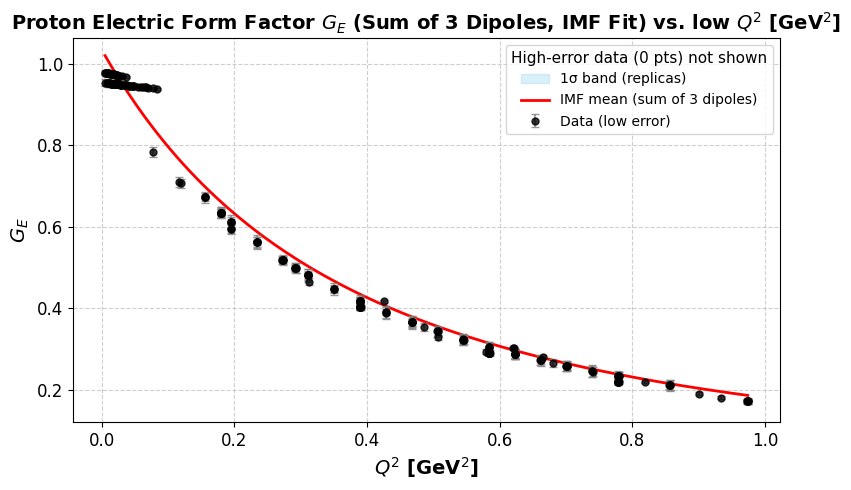

In [18]:
# === Load dataset ===
Q2 = df["Q2 [GeV^2]"].to_numpy()
GE = df["G_E_fit_sum3"].to_numpy()          # can be replaced with any G_E dataset
GE_err = df["delta_G_E_sum3"].abs().to_numpy()
normsys = df["G_E normsys [%]"].to_numpy() / 100.0  # convert % to fraction


# === Sum of 3 Dipole functions ===
def sum3_dipoles(Q2, G0_1, L1, G0_2, L2, G0_3, L3):
    return (G0_1 / (1 + Q2 / L1)**2
          + G0_2 / (1 + Q2 / L2)**2
          + G0_3 / (1 + Q2 / L3)**2)


# === Build IMF covariance ===
def build_covIMF(errs, model_vals, deltan):
    cov = np.diag(errs**2)
    return cov + (deltan**2) * np.outer(model_vals, model_vals)


# === Replica generation ===
def generate_replica(y, errs, deltan):
    yR = y + np.random.normal(scale=errs)
    nR = np.random.normal(1.0, deltan)
    return nR * yR


# === Residuals ===
def residuals(params, Q2, y_rep, covIMF_inv_sqrt):
    y_pred = sum3_dipoles(Q2, *params)
    return covIMF_inv_sqrt @ (y_rep - y_pred)


# === Bounded fit for multiprocessing ===
def fit_one_bounded(args):
    Q2, y_rep, covIMF_inv_sqrt, p0, bounds = args
    try:
        res = least_squares(
            residuals, p0, args=(Q2, y_rep, covIMF_inv_sqrt),
            bounds=bounds, max_nfev=3000
        )
        return res.x
    except Exception:
        return np.full(6, np.nan)


# === Stable IMF iteration for Sum of 3 Dipoles ===
def IMF_sum3_dipoles(Q2, y, yerr, deltan, R=200,
                     n_iter=6, tol=1e-4, n_cpu=None):
    if n_cpu is None:
        n_cpu = max(1, cpu_count() - 1)

    # --- initial guess: three dipoles with different Λ² scales ---
    p_hat = np.array([0.8, 0.5, 0.3, 1.0, 0.1, 2.0])  # [G0_1, L1, G0_2, L2, G0_3, L3]
    prev_mean = p_hat.copy()
    bounds = ([0, 0.05, 0, 0.05, 0, 0.05], [2, 3, 2, 3, 2, 3])

    for iteration in range(n_iter):
        Mhat = np.clip(sum3_dipoles(Q2, *p_hat), -2, 2)
        covIMF = build_covIMF(yerr, Mhat, deltan.mean()) + 1e-10 *(
             np.eye(len(Q2)))
        vals, vecs = np.linalg.eigh(covIMF)
        vals[vals < 1e-15] = 1e-15
        covIMF_inv_sqrt = vecs @ np.diag(1.0 / np.sqrt(vals)) @ vecs.T

        args_list = [(Q2, generate_replica(y, yerr, deltan.mean()), covIMF_inv_sqrt, p_hat, bounds)
                     for _ in range(R)]

        with Pool(processes=n_cpu) as pool:
            all_params = np.array(pool.map(fit_one_bounded, args_list))

        mask = ~np.isnan(all_params).any(axis=1)
        if mask.sum() == 0:
            print(f"Iter {iteration+1}: all fits failed — aborting.")
            break

        params_mean = all_params[mask].mean(axis=0)
        params_std = all_params[mask].std(axis=0, ddof=1)
        rel_change = np.linalg.norm(params_mean - prev_mean) / (
            np.linalg.norm(prev_mean) + 1e-12)

        print(f"Iter {iteration+1}: {mask.sum()}/{R} good fits, Δ={rel_change:.2e}")
        print(" mean:", params_mean)

        p_hat = params_mean.copy()
        if rel_change < tol:
            print("Converged.")
            break
        prev_mean = params_mean.copy()

    return params_mean, params_std, all_params[mask]


# === Run IMF fit ===
params_mean, params_std, params_reps = IMF_sum3_dipoles(Q2, GE, GE_err,
                                   normsys, R=300, n_iter=6, tol=5e-4)

print("\nFinal parameters (mean ± std):")
labels = ["G0₁", "Λ₁²", "G0₂", "Λ₂²", "G0₃", "Λ₃²"]
for lbl, m, s in zip(labels, params_mean, params_std):
    print(f"{lbl} = {m:.6e} ± {s:.6e}")



# === Prepare plot data ===
Q2_plot = np.linspace(Q2.min(), Q2.max(), 200)
GE_mean = sum3_dipoles(Q2_plot, *params_mean)
GE_samples = np.array([sum3_dipoles(Q2_plot, *p) for p in params_reps])
GE_low = np.percentile(GE_samples, 16, axis=0)
GE_high = np.percentile(GE_samples, 84, axis=0)

# --- Mask for low-error data ---
rel_err = GE_err / np.abs(GE)
mask_plot = rel_err < 0.2

# === Plot ===
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.title("Proton Electric Form Factor $G_E$ (Sum of 3 Dipoles, IMF Fit) vs. low $Q^2$ [GeV$^2$]",
          fontsize=14, fontweight='bold')

# --- 1σ band ---
plt.fill_between(Q2_plot, GE_low, GE_high, color='skyblue', alpha=0.3, label="1σ band (replicas)")

# --- IMF mean curve ---
plt.plot(Q2_plot, GE_mean, 'r-', lw=2, label="IMF mean (sum of 3 dipoles)")

# --- Data points with error bars ---
plt.errorbar(Q2[mask_plot], GE[mask_plot], yerr=GE_err[mask_plot],
             fmt='o', markersize=5, color='k',
             ecolor='gray', elinewidth=1.2, capsize=3,
             alpha=0.8, label="Data (low error)")

# --- Grid ---
plt.grid(True, linestyle='--', alpha=0.6)

# --- Labels ---
plt.xlabel(r"$Q^2$ [GeV$^2$]", fontsize=14, fontweight='bold')
plt.ylabel(r"$G_E$", fontsize=14, fontweight='bold')

# --- Tick styling ---
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# --- Legend ---
high_err_mask = ~mask_plot
plt.legend(title=f"High-error data ({high_err_mask.sum()} pts) not shown",
           fontsize=10, title_fontsize=11, loc="best")

# --- Layout ---
plt.tight_layout()
plt.show()


In [19]:
# === Proton charge radius (Sum of 3 Dipoles) ===
# Formula:
# r_E^2 = 12 * (ħc)^2 * (G01/Λ1^2 + G02/Λ2^2 + G03/Λ3^2) / (G01 + G02 + G03)
# Using (ħc) = 0.1973269804 GeV·fm

HC = 0.1973269804  # ħc in GeV·fm

def charge_radius_from_params(params):
    G01, L1, G02, L2, G03, L3 = params
    numerator = (G01 / L1 + G02 / L2 + G03 / L3)
    denominator = (G01 + G02 + G03)
    rE_sq = 12 * (HC**2) * numerator / denominator
    rE = np.sqrt(abs(rE_sq))
    return rE

# --- Mean radius from best-fit parameters ---
rE_mean = charge_radius_from_params(params_mean)

# --- Radius replicas for uncertainty estimation ---
rE_replicas = np.array([charge_radius_from_params(p) for p in params_reps])
rE_std = np.sqrt(np.mean(rE_replicas**2) - np.mean(rE_replicas)**2)

print(f"\nProton charge radius r_E = {rE_mean:.4f} ± {rE_std:.4f} fm")





Proton charge radius r_E = 0.8075 ± 0.0009 fm


Combined G_E uncertainty (first 5):
[0.00373385 0.00320873 0.00258732 0.00345408 0.00248076]
Chi-squared (χ²) = 10780.679
Degrees of freedom (ndf) = 199
Reduced chi-squared (χ²/ndf) = 54.174


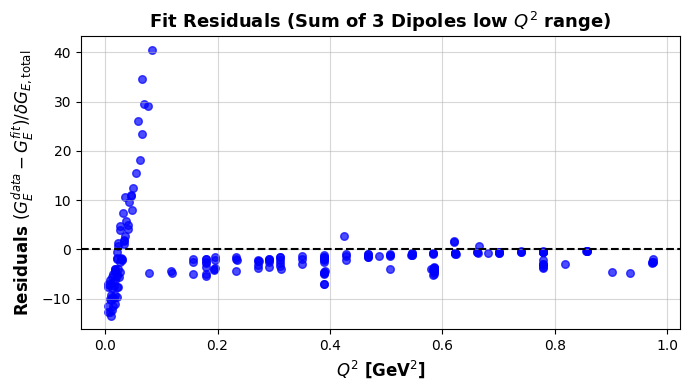

In [20]:
# === Goodness of Fit (Chi-squared) ===

# Predicted G_E values from the fitted model
GE_pred = sum3_dipoles(Q2, *params_mean)
# === Combine statistical and normalization uncertainties ===

G_err = np.sqrt(GE_err**2 + (GE * normsys)**2)

# Optional: check first few values
print("Combined G_E uncertainty (first 5):")
print(G_err[:5])

# Chi-squared numerator
chi2 = np.sum(((GE - GE_pred) / GE_err) ** 2)

# Degrees of freedom = number of data points - number of parameters
ndf = len(GE) - len(params_mean)

# Reduced chi-squared
chi2_reduced = chi2 / ndf

print(f"Chi-squared (χ²) = {chi2:.3f}")
print(f"Degrees of freedom (ndf) = {ndf}")
print(f"Reduced chi-squared (χ²/ndf) = {chi2_reduced:.3f}")

# Optional: visualize residuals
plt.figure(figsize=(7,4))
plt.scatter(Q2, (GE - GE_pred) / GE_err, s=30, c='blue', alpha=0.7)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel(r"$Q^2$ [GeV$^2$]", fontsize=12, fontweight='bold')
plt.ylabel(r"Residuals $(G_E^{data}-G_E^{fit})/\delta G_{E,\rm total}$",
           fontsize=12, fontweight='bold')
plt.title("Fit Residuals (Sum of 3 Dipoles low $Q^2$ range)",
          fontsize=13, fontweight='bold')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()
